# This is the development playground for functionalities for thermal profiler on DRU+ with Halliburton.

Now. Let's look at how each parameter affects the step response of the system when compared against the step input test data. This is for water at 600 rpm with 5% step input power.

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["step1_10p.csv", "step1_50p.csv", "step_5p.csv", "step_75p.csv"]:
    step_power = float(filename.split('p')[-2].split('_')[-1])/100
    my_fluid = MysteriousMud(filename)
    my_fluid.importRawData(filename, heaterHeader=True)

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rj,Rfj,Rf]
    # self.thermal_capacitances = [Cc, Cf]


    model.thermal_resistances = [.14, 2.210, 2.02, .0095] # Rf
    model.thermal_capacitances = [2000, 3000, 1200]

    model.thermal_resistances = [.14, 1.810, 1.32, .0095] # Rf
    model.thermal_capacitances = [2500, 3800, 1155]

    model.Tambient = 302


    
    x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
    temp_cell, temp_mud = model.stepResponse(x0, powerPercentage = step_power)
    model.plot(stepResponse=True)

Let's test on a 3rd order model.

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

Ch = 1000 #cap_ss * density_ss * d_heat**2 /4 * np.pi * l_heat * n_heaters
Rc = .1
Rj = 10
Cc = 6000
Cf = 1200
Rf = 0.1
Rfj = 5


Tn = 1500


def ss_model(t,x): # x = [Th-Tamb, Tc-Tamb; Tf-Tamb]

        A = np.array([[-1/Ch * (1/Rc + 1/Rj), 1/(Rc*Ch), 0],
                [1/(Rc*Cc), -1/Cc * (1/Rc + 1/Rf), 1/(Rf*Cc)],
                [0, 1/(Rf*Cf), -1/Cf * (1/Rfj + 1/Rf)]])
        B = np.array([1/Ch, 0, 0]).transpose() 
        C = np.array([0, 0, 1])

        if t > 0 and t < Tn/3:
            p = 100
        else:
            p = 0
        
        d = 0
        if p > 0:
            p = min(abs(p),1000)
        else:
            p = 0

        xdot = A @ x + B*p + d

        #print(x.shape, xdot)
        return xdot

Tambient = 300
tvec = np.linspace(0,Tn,1000)
X0 = np.zeros(3)
sol = solve_ivp(ss_model,(tvec[0],tvec[-1]), X0, t_eval=tvec)

yout = sol.y
temp_mud = yout[2,:] + Tambient
temp_cell = yout[1,:] + Tambient
temp_heater = yout[0,:] + Tambient



plt.figure()
plt.plot(tvec,temp_heater, label = "heater temp")
plt.plot(tvec,temp_cell, label = "cell temp")
plt.plot(tvec,temp_mud, label = "mud temp")

plt.legend()

Looks a lot better!

# Now, testing plotting and simulation suites


In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["calibration_fluid_50p.csv", "calibration_fluid_pid1.csv", "calibration_fluid_pid2.csv"]:

    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.11, 1.65, 1.35, .001] # Rf
    model.thermal_capacitances = [2000, 3000, 460]

    model.thermal_resistances = [.125, 1.810, 1.32, .00095] # Rf
    model.thermal_capacitances = [2000, 3000, 740]
    model.Tambient = 300

    x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
    model.forcedResponse(x0)
    model.plot()

    #model.bode_plot()
 

 

# Estimating the viscous heating from bob with simple model

In [ ]:
import numpy as np

bob_radius = 0.03454/2
radial_spacing = .0015


sample_viscosity = 0.1 # mu for calibration oil
sample_viscosity = 1.5 # glycerol room temp
volume = 0.0003 # cubic meters

rpm = 600

q = volume * sample_viscosity * (bob_radius*rpm*2*np.pi/60/radial_spacing)**2

print(f"The viscous heating from the bob at {rpm} rpm with mu = {sample_viscosity*1000} cP is: {q} Watts")

Note that from ambient (~29 C) leaving the rotor at 600 rpm doesn't increase the temperature at all for calibration fluid.

For glycerol however, it theoretically should be noticable since it is almost 1/4 of the 100% heater output on the cell. And it is. Shown below. Though it doesn't seem the above approximation is right. Or some values I'm using are wrong.



In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["viscous_heating_test.csv"]:

    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.13, 1.2, 2.6, .0018] # Rf
    model.thermal_capacitances = [2000, 3000, 1000]
    model.Tambient = 300

    x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
    model.forcedResponse(x0)
    model.plot()
 

 

Testing data fits on mud sample

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["mud_pid1.csv"]:

    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.13, 1.2, 2.6, .0018] # Rf
    model.thermal_capacitances = [2000, 3000, 100]
    model.Tambient = 300

    x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
    model.forcedResponse(x0)
    model.plot()
 

 

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["water_50p.csv", "water_pid1.csv", "water_111p.csv", "water_pid2.csv"]:

    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)


    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.125, 1.810, 1.32, .00095] # Rf
    model.thermal_capacitances = [2300, 3800, 1400]

    model.Tambient = 300

    x0 = np.array([1,1,1]) * my_fluid.temp_cell[0]
    y3 = model.forcedResponse(x0)
    model.plot()

    

Now let's use recursive least squares parameter estimation to measure properties in real time!


In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *


# initialize RLS params
n = 8 # number of parameters
m = 3 # number of measured outputs

P0 = np.eye(n) * 1e10

# to simulate this, parse through each time step in a given data set

# read in test data
filename = "water_pid2.csv"
filename = "calibration_fluid_pid1.csv"
#filename = "glycerol_pid1.csv"

my_fluid = MysteriousMud(filename)
my_fluid.importRawData(filename, heaterHeader=True)

Nk = len(my_fluid.tvector)
sT = 1 # sampling time of sT seconds


Pp = P0
Powerp, Thp, Tcp, Tfp = 1,15,15,15


Rc, Rj, Rfj, Rf = [.14, 1.810, 1.32, .0095]
Ch, Cc, Cf = [2500, 3800, 1255]


thetap = np.array([sT/Ch, 1-sT*(1/Rj + 1/Rc)/Ch, sT/(Rc*Ch), 1 - sT*(1/Rc + 1/Rf)/Cc, sT/Rc/Cc, sT/Rf/Cc, sT/Rf/Cf, 1-sT*(1/Rf + 1/Rfj)/Cf])
c1,c2,c3,c4,c5,c6,c7,c8 = thetap

thetap.resize((n,1))

print("Right constants: ", thetap)

thetap = np.zeros((n,1))

theta_history = []



for k in range(Nk):

    yk = np.array([my_fluid.temp_cell[k], my_fluid.temp_fluid[k], my_fluid.temp_fluid[k]]) - 300

    
    Powerk = my_fluid.heater_dutycycle[k]/100 * 1000 # in Watts now


    Rk = np.eye(m)/10


    Hk = np.matrix([[Powerp, Thp, Tcp, 0,0,0,0,0],[0,0,0,Tcp,Thp,Tfp,0,0],[0,0,0,0,0,0,Tcp, Tfp]])


    bigInverse = (Hk @ Pp @ Hk.T + Rk).I
    Kk = Pp @ Hk.T @ bigInverse

    Pk = (np.eye(n) - (Kk @ Hk)) @ Pp

    #print('##########################')
    #print(Pk)

    theta_error = (yk.reshape(m,1) - (Hk@thetap))

    predicted_y = np.asarray(Hk@thetap)

    thetak =  np.asarray(thetap + Kk @ theta_error)
    thetak[0] = c1
    thetak[1] = c2
    thetak[2] = c3
    thetak[4] = c5
    thetak[3] = 1-c5-thetak[5]
    
    #print(yk - np.asarray((Hk@thetap).T))

    #thetak = abs(thetak)

    Pp = Pk
    thetap = thetak
    Thp, Tcp, Tfp = list(yk)
    Powerp = Powerk
    theta_history.append(predicted_y)
    

print("Done running RLS!")

print("Parameters: ", thetak)

print(np.max(Pk))

c1,c2,c3,c4,c5,c6,c7,c8 = [x[0] for x in thetak]

Ch = sT/c1
Rc = sT/(Ch*c3)
Rj = 1/((1-c2)/sT * Ch - 1/Rc)
Cc = sT/(Rc*c5)
Rf = sT/(Cc*c6)
Cf = sT/(Rf*c7)
Rfj = 1/(Cf*(1-c8)/sT - 1/Rf)

print("c456 sum [should be close to 1]: ", c4 + c5 + c6)



model = ThermalModel(my_fluid)

model.thermal_resistances = [Rc, Rj,Rfj,Rf]
model.thermal_capacitances = [Ch, Cc, Cf]

model.Tambient = 300

x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
model.forcedResponse(x0)
model.plot()

##

# look at what RLS is cookin'


mean_error = np.array(theta_history)

plt.figure()
plt.plot(my_fluid.tvector,mean_error[:,0])
plt.plot(my_fluid.tvector,mean_error[:,1])
plt.plot(my_fluid.tvector,mean_error[:,2])

plt.plot(my_fluid.tvector,my_fluid.temp_cell-300,'--')
plt.plot(my_fluid.tvector,my_fluid.temp_fluid-300,'--')
plt.xlabel("Time [s]")
plt.ylabel("Temperature - Tamb [K]")

Interesting how the RLS think's it's on the money, when it's not. I'm thinking this is because of the lack of the forgetting factor or the model is not discretized properly.

# Looking at sensitivity of each parameter.

For each parameter, loop through interval and plot mean error against the parameter value. Look for concavity if any. Refer to the sensitivity_studies.ipynb file for more info.

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["glycerol_50p.csv"]:

    my_fluid = MysteriousMud(filename)
    my_fluid.importRawData(filename, heaterHeader=True)
    model = ThermalModel(my_fluid)


    mean_errors = []
    p_space = np.linspace(300,1500,10)
    

    for p in p_space:
        model.thermal_resistances = [.14, 1.810, 1.32, .0095] # Rf
        model.thermal_capacitances = [2500, 3800, p] #1155]
        model.Tambient = 300

        x0 = np.array([1,1,1]) * my_fluid.temp_cell[0]
        model.forcedResponse(x0)
        
        plt.figure(10)
        model.bode_plot()
    


In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
for filename in ["water_sensitivity.csv","oil_sensitivity.csv"]:

    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [0.013, 0.001, .001, .08018] # Rf
    model.thermal_capacitances = [200, 30, 10]
    model.Tambient = 300

    x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
    s0 = np.array([0,0,0])
    X0 = np.concatenate([x0,s0])
    print("Initial conditions: ", x0)
    yout = model.sensitivityResponse(X0)


Confirming that the expm function works against the Cayley Hamilton method

Looking at Cayley-Hamilton compared to python's expm function

In [ ]:
import numpy as np
from scipy.linalg import expm, logm

A = np.matrix([[0.76330305, 0.15036146, 0.70429554], 
 [0.14351586, 0.37585963, 0.11562032],
 [0.59144264, 0.86482302, 0.19785867]])


print(A)
l1,l2,l3 = np.linalg.eigvals(A)

k = np.matrix([[1,l1,l1**2],[1,l2,l2**2], [1,l3,l3**2]])
x = np.array([np.exp(2*l1), np.exp(2*l2), np.exp(2*l3)])
alphas = k.I @ x


a1,a2,a3 = alphas[0,0], alphas[0,1], alphas[0,2]

eACH = a1 * np.eye(3) + a2 * A + a3 * A**2

eA = expm(A) @ expm(A)

print(eA - eACH) # the difference should be close to 0

print(logm(eA)/2) # getting A back


Looking at how profiles compare with other samples with different heat capacity.

In [ ]:
%matplotlib widget

from dru_thermal_model import *
from data_visualizer import *

# read in test data
plt.figure(figsize=(10,5))
for filename in ["water_sensitivity.csv","oil_sensitivity.csv"]:

    my_fluid = MysteriousMud(filename)
    try:
        my_fluid.importRawData(filename, heaterHeader=True)
    except FileNotFoundError:
        print(f"{filename} file not found!")
        continue

    except:
        raise

    model = ThermalModel(my_fluid)

    # self.thermal_resistances = [Rc, Rj,Rfj,Rf]
    # self.thermal_capacitances = [Ch, Cc, Cf]

    model.thermal_resistances = [.13, 1.2, 2.6, .0018] # Rf
    model.thermal_capacitances = [2000, 3000, 1000]
    model.Tambient = 300

    x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
    model.forcedResponse(x0)
    model.plot(newfig=False, includeSim=False)

So... with oil the fluid temperature reacts more sluggishly and the cell temperature simply rises for longer though the transient looks the same.

FLUID DATA FOR BARAECD Fluid REFERENCED AT  25-Jul-24 21:59:16:598
###############  BARAECD Fluid   ################
Rc, Rj, Rfj, Rf: [0.13, 1.2, 2.6, 0.0018]
Ch, Cc, Cf: [2000, 3000, 1000]
###################################################
Fluid specific heat: 2700.0


<Figure size 1000x500 with 0 Axes>

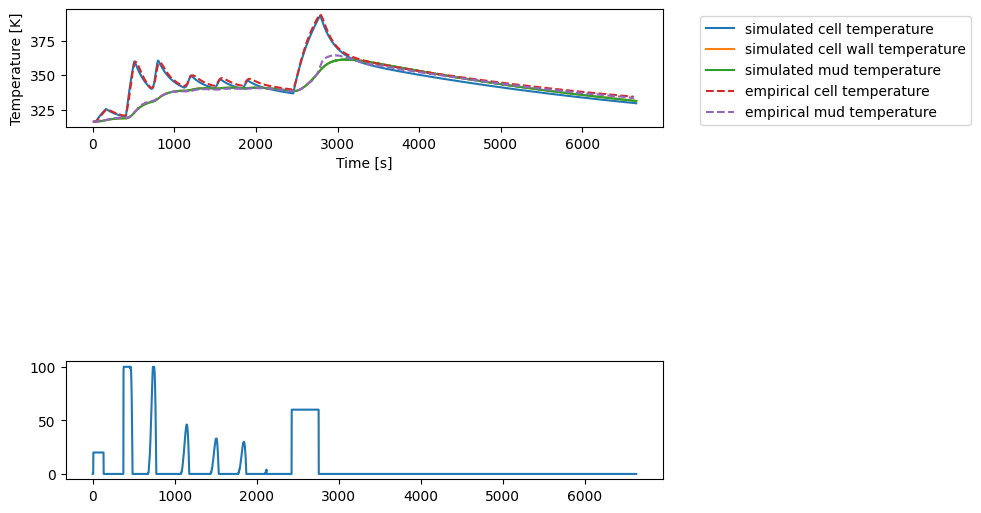

In [1]:
from dru_thermal_model import *
from data_visualizer import *

# read in test data
plt.figure(figsize=(10,5))
filename = "mud_pid1.csv"
sample_name = "BARAECD Fluid"
my_fluid = MysteriousMud(sample_name) # name the sample
my_fluid.importRawData(filename) # load in raw data

model = ThermalModel(my_fluid) # instantiate the model

# self.thermal_resistances = [Rc, Rj,Rfj,Rf]
# self.thermal_capacitances = [Ch, Cc, Cf]

# externally set the system parameters
model.thermal_resistances = [.13, 1.2, 2.6, .0018] # Rf
model.thermal_capacitances = [2000, 3000, 1000]
model.Tambient = 300 # set the ambient temperature

x0 = np.array([my_fluid.temp_cell[0],my_fluid.temp_fluid[0],my_fluid.temp_fluid[0]]) 
model.forcedResponse(x0)
model.plot()